In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

### Preparing data

In [144]:
# Categorical features.
DICT_INTENT = ['DEBTCONSOLIDATION','EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']
DICT_PHO =  ['MORTGAGE', 'OTHER', 'OWN', 'RENT']

def row_to_numbers(row):
  # Add all numerical features.
  ans = [
    row['person_age'],row['person_income'],row['person_emp_length'],row['loan_amnt'],
    row['loan_int_rate'], row['loan_percent_income'], row['cb_person_cred_hist_length']
  ]
  
  loan_grade = 7 - (ord(row['loan_grade'])-ord('A'))
  assert 1 <= loan_grade <= 7
  ans += [loan_grade]
  
  pdof = row["cb_person_default_on_file"]
  assert pdof in "NY"
  ans += [1 if pdof=="Y" else 0]
  
  ans += [int(row["loan_intent"]==DICT_INTENT[i]) for i in range(len(DICT_INTENT))]
  ans += [int(row["person_home_ownership"]==DICT_PHO[i]) for i in range(len(DICT_PHO))]
  
  return ans
  
def df_to_x(df):
  ans = []
  for _, row in df.iterrows():
    ans.append(row_to_numbers(row))
  return np.array(ans)

def df_to_y(df):
  return np.array([row['loan_status'] for _, row in df.iterrows()])



df_train = pd.read_csv('train.csv')
X_train_full = df_to_x(df_train)
y_train_full = df_to_y(df_train)

In [145]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(52780, 19) (52780,) (5865, 19) (5865,)


### Training

In [147]:
#logreg = LogisticRegression(random_state=16)
#logreg.fit(X_train, y_train)

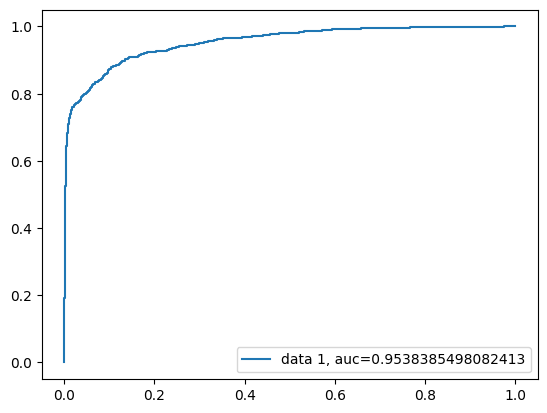

In [146]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dval_reg = xgb.DMatrix(X_val)

params = {
  "objective": "reg:logistic",
  "eval_metric": "auc",
  "tree_method":"auto",
  #"eta":0.03
}

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=150,
)

#y_pred_proba = logreg.predict_proba(X_val)[::,1]
y_pred_proba = model.predict(dval_reg)
fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [119]:
df_test = pd.read_csv('test.csv')
X_test = df_to_x(df_test)
print(X_test.shape)

#y_pred = logreg.predict_proba(X_test)[::,1]
y_pred = model.predict(xgb.DMatrix(X_test))

df_ans = pd.DataFrame({"id":df_test['id'], "loan_status": y_pred})
df_ans.to_csv('ans.csv',index=False)

(39098, 19)
